In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist

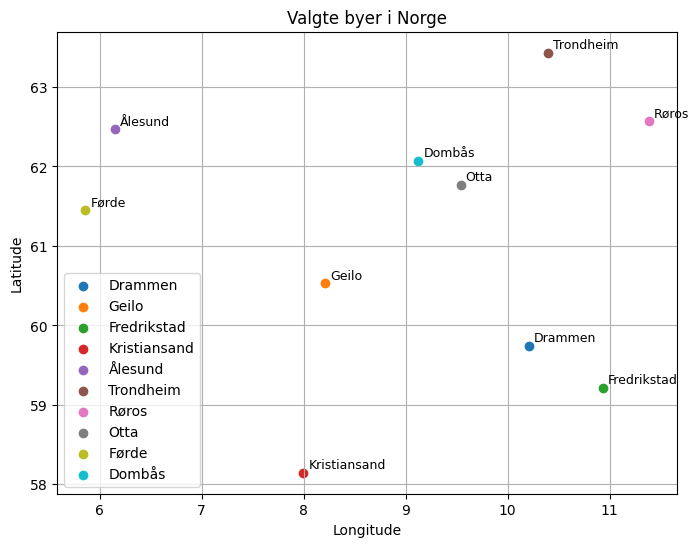

In [20]:
# Norske byer med koordinater (latitude, longitude)
cities = {
    "Drammen": (59.7439, 10.2045),
    "Geilo": (60.5323, 8.2086),
    "Fredrikstad": (59.2180, 10.9298),
    "Kristiansand": (58.1467, 7.9956),
    "Ålesund": (62.4722, 6.1495),
    "Trondheim": (63.4305, 10.3951),
    "Røros": (62.5741, 11.3841),
    "Otta": (61.7714, 9.5375),
    "Førde": (61.4520, 5.8566),
    "Dombås": (62.0743, 9.1240)
}

# Konverter til en liste av bynavn og koordinater
city_names = list(cities.keys())
city_coords = np.array(list(cities.values()))

# Plotter byene i et grid
plt.figure(figsize=(8, 6))
for i, (city, coord) in enumerate(cities.items()):
    plt.scatter(coord[1], coord[0], marker='o', label=city)  # Longitude (x) vs Latitude (y)
    plt.text(coord[1] + 0.05, coord[0] + 0.05, city, fontsize=9)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Valgte byer i Norge")
plt.legend()
plt.grid()
plt.show()

In [24]:
# Kalkulerer Euclidean distance matrix for alle byene
distance_matrix = cdist(city_coords, city_coords, metric='euclidean')

# Printer matrisen.
print("Distance Matrix:\n", np.round(distance_matrix, 2))

Distance Matrix:
 [[0.   2.15 0.9  2.73 4.89 3.69 3.07 2.13 4.67 2.57]
 [2.15 0.   3.02 2.4  2.83 3.63 3.78 1.82 2.53 1.79]
 [0.9  3.02 0.   3.12 5.78 4.25 3.39 2.91 5.54 3.38]
 [2.73 2.4  3.12 0.   4.7  5.8  5.58 3.94 3.94 4.09]
 [4.89 2.83 5.78 4.7  0.   4.35 5.24 3.46 1.06 3.  ]
 [3.69 3.63 4.25 5.8  4.35 0.   1.31 1.87 4.95 1.86]
 [3.07 3.78 3.39 5.58 5.24 1.31 0.   2.01 5.64 2.31]
 [2.13 1.82 2.91 3.94 3.46 1.87 2.01 0.   3.69 0.51]
 [4.67 2.53 5.54 3.94 1.06 4.95 5.64 3.69 0.   3.33]
 [2.57 1.79 3.38 4.09 3.   1.86 2.31 0.51 3.33 0.  ]]


In [42]:
class PSO_TSP:
    def __init__(self, distance_matrix, num_particles=100, max_iter=200, inertia=0.8, cognitive=1.5, social=1.5):
        self.distance_matrix = distance_matrix
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.inertia = inertia
        self.cognitive = cognitive
        self.social = social
        self.num_cities = len(distance_matrix)

        # Tester tilfeldige ruter
        self.particles = [np.random.permutation(self.num_cities) for _ in range(self.num_particles)]
        self.velocities = [np.zeros(self.num_cities) for _ in range(self.num_particles)]

        # Finner de beste rutene imellom de forskjellige byene
        self.p_best = list(self.particles)
        self.p_best_costs = [self.route_cost(route) for route in self.particles]

        # Finner den beste ruten imellom alle byene
        self.g_best = self.p_best[np.argmin(self.p_best_costs)]
        self.g_best_cost = min(self.p_best_costs)

        # Lagrer kostnadshistorikk for konvergensplott
        self.best_costs = []

    def route_cost(self, route):
        """Kalkulerer den totale distansen for hver enkelt rute"""
        cost = 0
        for i in range(len(route) - 1):
            cost += self.distance_matrix[route[i], route[i+1]]
        cost += self.distance_matrix[route[-1], route[0]]  # Return to start
        return cost

    def swap(self, route, i, j):
        """Lager en ny rute ved å bytte om på to forskjellige byer i rekkefølgen"""
        new_route = route.copy()
        new_route[i], new_route[j] = new_route[j], new_route[i]
        return new_route

    def update_particles(self):
        """Oppdaterer partiklene ved hjelp av posisjons oppdateringer"""
        for i in range(self.num_particles):
            # Bytter tilfeldig
            swap_indices = np.random.randint(0, self.num_cities, 2)
            
            # Lager en ny rute for å teste tilfeldig
            new_route = self.swap(self.particles[i], swap_indices[0], swap_indices[1])
            new_cost = self.route_cost(new_route)

            # Oppdaterer costen (den beste ruten) ifra en by til en annen
            if new_cost < self.p_best_costs[i]:
                self.p_best[i] = new_route
                self.p_best_costs[i] = new_cost

            # Oppdaterer den totalt costen (beste ruten) imellom alle byene.
            if new_cost < self.g_best_cost:
                self.g_best = new_route
                self.g_best_cost = new_cost

            # Forrandrer ruten ut ifra de tilfeldige byttene
            self.particles[i] = new_route

    def optimize(self, stop_threshold=40): #Setter manuell stopp på 40 ved ingen forbedring
        """Kjører PSO algoritmen"""
        no_improve_count = 0  # Teller iterasjoner uten forbedring
        last_best_cost = self.g_best_cost  # Initialiser forrige beste kostnad

        for iteration in range(self.max_iter):
            self.update_particles()
            self.best_costs.append(self.g_best_cost)  # Lagrer beste kostnad for konvergensplott

            # sjekker om den beste løsningen har forbedret seg
            if self.g_best_cost < last_best_cost:
                last_best_cost = self.g_best_cost
                no_improve_count = 0  # Tilbakestiller telleren
            else:
                no_improve_count += 1  # Øk telleren ved ingen forbedring

            # Stopp tidlig
            if no_improve_count >= stop_threshold:
                print(f"Stoppet tidlig ved iterasjon {iteration} (ingen forbedring på {stop_threshold} iterasjoner)")
                break

            # Printer progresjon for hver 10. iterasjon
            if iteration % 10 == 0 or iteration == self.max_iter - 1:
                print(f"Iteration {iteration}: Best Cost = {self.g_best_cost:.2f}")

        return self.g_best, self.g_best_cost, self.best_costs


# Kjører PSOen for å løse oppgaven
pso_solver = PSO_TSP(distance_matrix, num_particles=100, max_iter=200)
best_route, best_cost, cost_history = pso_solver.optimize()

Iteration 0: Best Cost = 24.72
Iteration 10: Best Cost = 20.75
Iteration 20: Best Cost = 20.75
Iteration 30: Best Cost = 20.75
Iteration 40: Best Cost = 20.75
Stoppet tidlig ved iterasjon 50 (ingen forbedring på 40 iterasjoner)


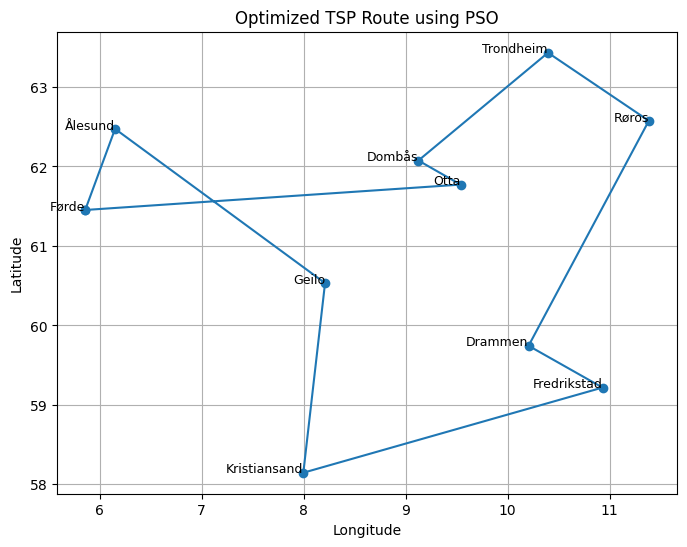

In [43]:
def plot_route(route, cities):
    """Plot the best route on a 2D map"""
    plt.figure(figsize=(8, 6))
    
    # Henter fram kordinatene
    ordered_coords = np.array([city_coords[i] for i in route] + [city_coords[route[0]]])

    # Plotter ruten
    plt.plot(ordered_coords[:,1], ordered_coords[:,0], marker='o', linestyle='-')

    # Label cities
    for i, city in enumerate(route):
        plt.text(city_coords[city][1], city_coords[city][0], city_names[city], fontsize=9, ha='right')

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Optimized TSP Route using PSO")
    plt.grid()
    plt.show()

# Plotter den beste ruten
plot_route(best_route, cities)

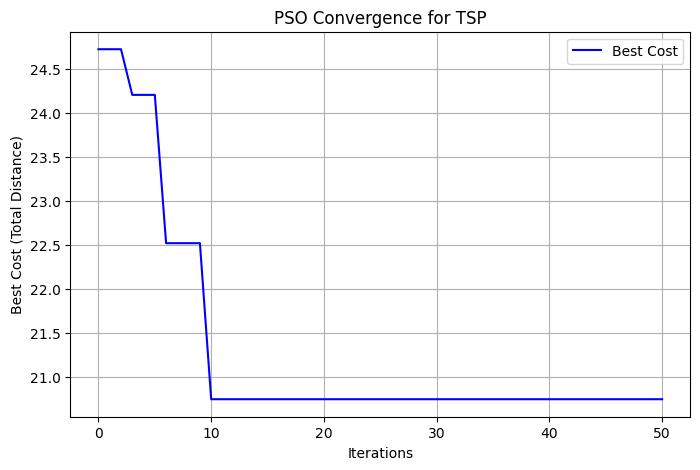

In [44]:
def plot_convergence(cost_history):
    """Plotter konvergensgrafen for å vise kostnadsreduksjon"""
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(cost_history)), cost_history, label="Best Cost", color="blue")
    plt.xlabel("Iterations")
    plt.ylabel("Best Cost (Total Distance)")
    plt.title("PSO Convergence for TSP")
    plt.legend()
    plt.grid()
    plt.show()

# Plotter konvergensgrafen
plot_convergence(cost_history)